## Activity 04
### Tyler Barna

In [1]:
## import modules (running on python 3.9.12)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pymc3 as pm
import random
import scipy
import seaborn as sns


import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import nbinom

## set seed for reproducibility
random.seed(5731) 

## import data
df = pd.read_csv('Number_PNe.txt', sep='\s+')
df['N_PN'] = df['N_PN'].astype(int)

df.head()

,galaxy,N_PN
0,FCC083,63
1,FCC119,14
2,FCC143,13
3,FCC147,98
4,FCC148,58


Let's find some basic stats on the data set.


Number of galaxies: 21
Total Number of PNe: 1162
Max number of PNe in one galaxy: 159
Min number of PNe in one galaxy: 10
Mean number of PNe per galaxy: 55.3
Median number of PNe per galaxy: 45.0
Standard deviation of number of PNe per galaxy: 39.1


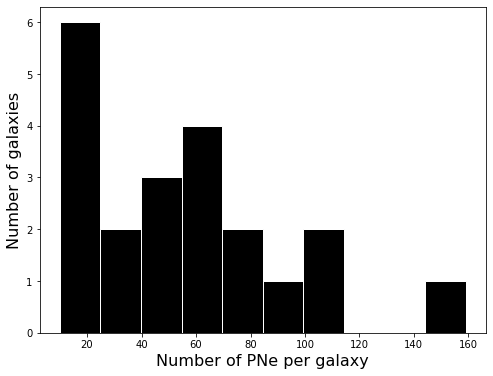

In [2]:
## find and print basic stats
print('Number of galaxies: %s'%df.shape[0])
print('Total Number of PNe: %s'%df['N_PN'].sum())
print('Max number of PNe in one galaxy: %s'%df['N_PN'].max())
print('Min number of PNe in one galaxy: %s'%df['N_PN'].min())
print('Mean number of PNe per galaxy: %s'%round(df['N_PN'].mean(),1))
print('Median number of PNe per galaxy: %s'%df['N_PN'].median())
print('Standard deviation of number of PNe per galaxy: %s'%round(df['N_PN'].std(),1))

## plot histogram of number of PNe per galaxy
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
ax.hist(df['N_PN'], color='k', edgecolor='w');
plt.xlabel('Number of PNe per galaxy', fontsize=16)
plt.ylabel('Number of galaxies', fontsize=16);
plt.show();

Our goal is to predict how many planetary nebulae we would expect to see in a given galaxy. I will first develop the standard prior and posterior models that we have developed in prior activities before doing a prior predictive check to estimate the number of planetary nebulae. In this case, we will be using a beta distribution for the prior and a beta distribution for the posterior. The *likelihood* will actually be the negative binomial distribution.

First, we'll do the prior:

$$\begin{equation}
\theta \sim \text{Beta}(b, c)
\end{equation}$$

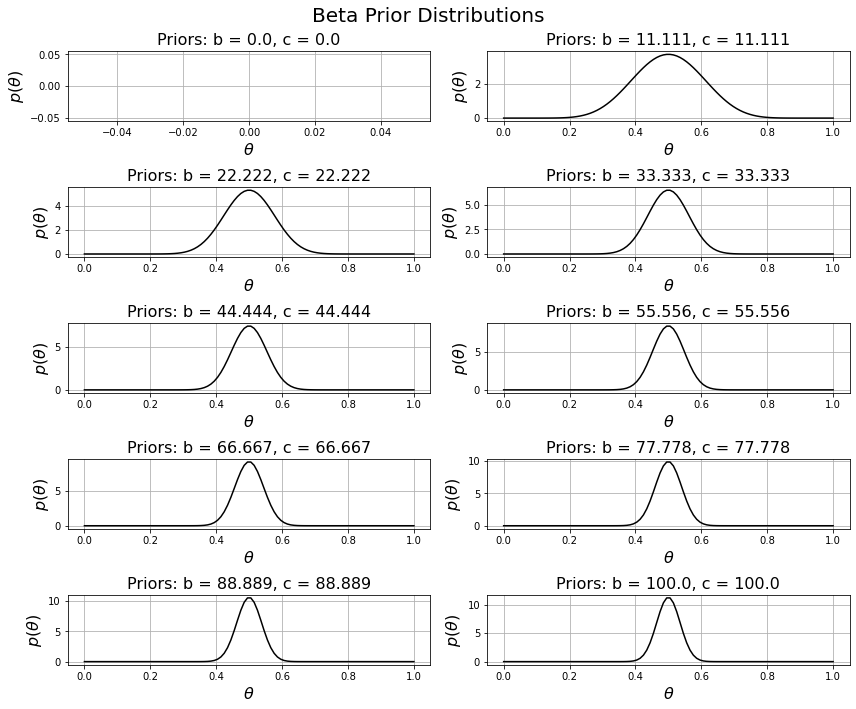

In [3]:
## develop beta prior distribution
n_priors = 10
b,c = np.linspace(0, 100, n_priors), np.linspace(0, 100, n_priors)

def prior(bc):
    b , c = bc
    x = np.linspace(0, 1, 100)
    prior = beta.pdf(x, b, c)
    return prior

def plot_prior(n_priors = 10, bc=(1,1)):
    b,c = bc
    fig, axs = plt.subplots(int(n_priors/2), 2, facecolor='w',figsize=(12,n_priors))
    fig.set_tight_layout(True)
    idx = 0
    for b,c in zip(b,c):
        ax = axs.flatten()[idx]
        x = np.linspace(0, 1, 100)
        y = prior((b,c))
        ax.plot(x,y, color='k');
        ax.set_title('Priors: b = %s, c = %s'%(round(b,3),round(c,3)), fontsize=16)
        ax.grid()
        ax.set_xlabel(r'$\theta$', fontsize=16)
        ax.set_ylabel(r'$p(\theta)$', fontsize=16)
        idx+=1
    fig.suptitle('Beta Prior Distributions', fontsize=20)
    return fig, axs
y = lambda b,c: beta.pdf(x,b,c)

plot_prior(n_priors=n_priors, bc = (b,c));


These are parallel, so it might be good to also try it with a random distribution of priors

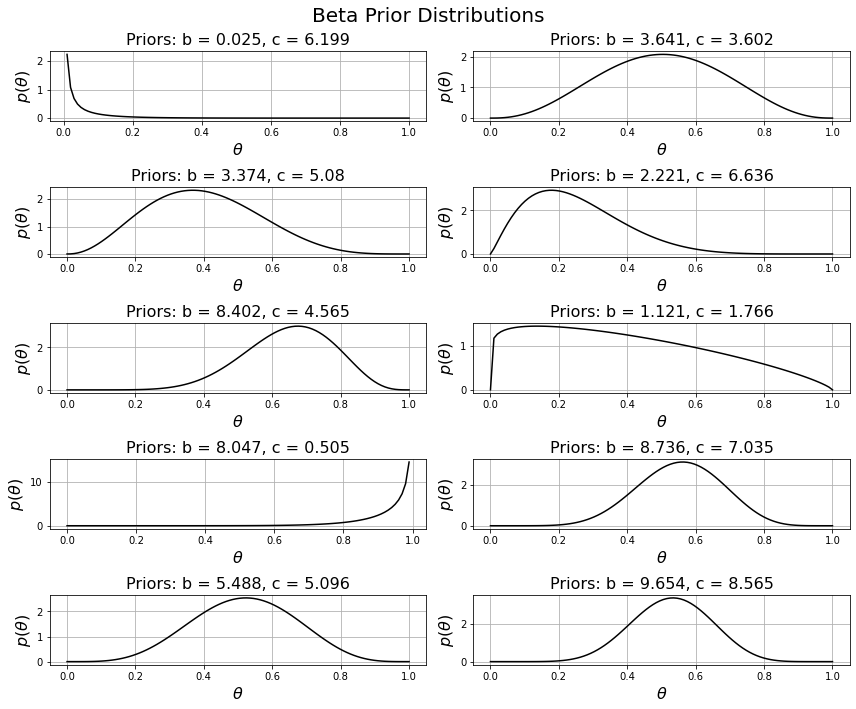

In [4]:
n_priors = 10
max_prior = 10
b,c = np.random.random(n_priors)*max_prior, np.random.random(n_priors)*max_prior

plot_prior(n_priors=n_priors, bc = (b,c));

It's hard to make a judgement call on what the prior should be, but we ultimately settled on using $a=20$, $b=1$, and $c=5$. The posterior is also a beta distribution

$$\begin{equation}
\text{Posterior} \sim \text{Beta}\left( n a +b, \ n \bar{x} +c \right)
\end{equation}$$

where $n$ is the number of galaxies in the sample and $\bar{x}$ is the average number of planetary nebulae per galaxy in the sample.

Expected value of theta: 0.013


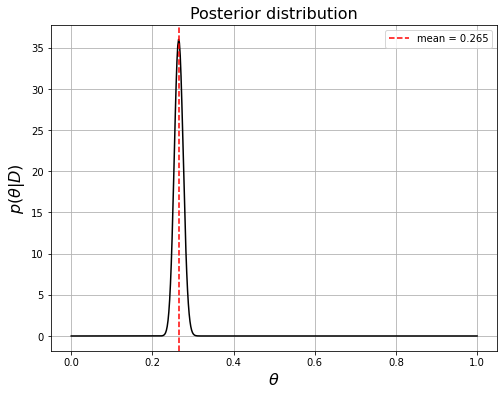

In [5]:
## create function to calculate posterior distribution
def posterior(df, abc):
    x = np.linspace(0,1,500)
    a,b,c = abc
    n = df.shape[0]
    post_a = n*a + b
    post_b = n*df['N_PN'].mean() + c
    post = beta.pdf(x,post_a,post_b)
    return post, post_a, post_b

def plot_post(df, abc=[1,1,1]):
    ## calculating posterior
    a, b, c = abc
    x = np.linspace(0,1,500)
    post, post_a, post_b = posterior(df, abc)
    mean, var, skew, kurt = beta.stats(post_a, post_b, moments='mvsk')
    exp_theta = mean/(mean+a)
    print('Expected value of theta: %s'%round(exp_theta,3))

    ## plotting
    fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
    ax.plot(x,post, color='k');
    ax.axvline(mean, color='r', linestyle='--', label='mean = %s'%mean.round(3))

    ax.set_title('Posterior distribution', fontsize=16)
    ax.grid()
    ax.set_xlabel(r'$\theta$', fontsize=16)
    ax.set_ylabel(r'$p(\theta|D)$', fontsize=16)
    ax.legend()
    return fig, ax

plot_post(df, abc=[20,1,5]);

Now, let's move onto the Posterior Predictive Check which will allow us to estimate the number of planetary nebulae in a galaxy.

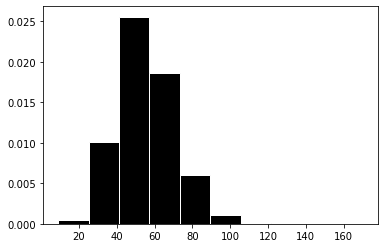

In [9]:
abc = [20,1,5]
post, post_a, post_b = posterior(df, abc)
# print('Posterior a: %s'%post_a)
# print('Posterior b: %s'%post_b)

n_sim = 1000000
x_js = np.zeros(n_sim)
x_js = [
np.random.negative_binomial(
    abc[0], np.random.beta(post_a,post_b)) 
for i in range(n_sim)
]

plt.hist(x_js, density=True, color='k', edgecolor='w');

This isn't necessarily exactly what we expected to see for a negative binomial, but our analysis would benefit from using a more robust method for doing the posterior predictive check